In [11]:
from collections import Counter
import pandas as pd
import math
import numpy as np

import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [12]:
noise_level_step = 0.0025
noise_levels_count = 160
noise_levels_idx = list(range(noise_levels_count))
noise_levels = np.array([(i + 1) * noise_level_step for i in noise_levels_idx])

def noise_from_index(idx):
    return noise_levels[int(idx) - 1] if not math.isnan(idx) and idx > 0 else 0

def noise_from_value(val):
    return np.searchsorted(noise_levels, val, side='right') if not math.isnan(val) else 0 # exact values will give +1 to get proper value for 0 noise level

In [13]:
mera_df = pd.read_json("mera.json")

mera_df['noise_idx'] = mera_df['noise_level'].apply(lambda x: x+1 if not math.isnan(x) else 0)
mera_df['noise_level'] = mera_df['noise_idx'].apply(lambda x: noise_from_index(x))


mean_mera_df = mera_df.groupby(by=['dataset', 'model', 'noise_level']).mean()
mean_mera_df = mean_mera_df.reset_index()

In [14]:
mera_sbs_df = pd.read_json("mera_sbs.json")

mean_mera_sbs_df = mera_sbs_df.groupby(by=['dataset', 'model', 'noise_level']).mean()
mean_mera_sbs_df = mean_mera_sbs_df.reset_index()

In [15]:
sbs_df = pd.read_json("votes_sbs.json")
wers_df = pd.read_json("wers.json")
meaning_df = pd.read_json("votes_check.json")

meaning_df['dataset'] = meaning_df['dataset'].apply(lambda ds: ds[len('LibriSpeech/'):])
sbs_df['dataset'] = sbs_df['dataset'].apply(lambda ds: ds[len('LibriSpeech/'):])

In [16]:
# normalizing datasets
wers_df['noise_idx'] = wers_df['noise_level'].apply(lambda x: noise_from_value(x))
wers_df['noise_level'] = wers_df['noise_idx'].apply(lambda x: noise_from_index(x))

meaning_df['noise_idx'] = meaning_df['level_idx'].apply(lambda x: x+1 if not math.isnan(x) else 0)
meaning_df['noise_level'] = meaning_df['noise_idx'].apply(lambda x: noise_from_index(x))
del meaning_df['level_idx']

In [17]:
# sbs slices
def slice_by_level(level_idx: int):
    level = level_idx - 1 if level_idx > 0 else math.nan
    result = pd.DataFrame(sbs_df.loc[(sbs_df.more_noise_idx == level) | (sbs_df.less_noise_idx == level)])

    result['noise_index'] = result.apply(lambda row: row['more_noise_idx'] if row['less_noise_idx'] == level else row['less_noise_idx'], axis = 1)
    result['votes_ok'] = result.apply(lambda row: row['more_noise_votes'] if row['less_noise_idx'] == level else row['less_noise_votes'], axis = 1)
    result['votes_total'] = result.apply(lambda row: row['more_noise_votes'] + row['less_noise_votes'], axis = 1)
    result['noise_idx'] = result['noise_index'].apply(lambda x: int(x+1 if not math.isnan(x) else 0))
    result['noise_level'] = result['noise_idx'].apply(lambda x: noise_from_index(x))

    del result['more_noise_idx']
    del result['less_noise_idx']
    del result['noise_index']
    del result['more_noise_votes']
    del result['less_noise_votes']
    
    return result



sbs_slices = {
     noise_from_value(0.10): slice_by_level(noise_from_value(0.10)),
}

In [18]:
def betta_variance(alpha, betta):
    return math.sqrt(alpha * betta / (alpha + betta) / (alpha + betta) / (alpha + betta + 1))

In [19]:
meaning_df['better'] = meaning_df.apply(lambda row: (row['votes_total'] - row['votes_ok'])/row['votes_total'], axis=1)
meaning_df['error'] = meaning_df.apply(lambda row: 3 * betta_variance(row['votes_ok']/5 + 1, (row['votes_total'] - row['votes_ok'])/5 + 1), axis=1)
meaning_df = meaning_df.sort_values(by='noise_level')

In [20]:
for sbs_basis, sbs_slice in sbs_slices.items():    
    sbs_slice['better'] = sbs_slice.apply(lambda row: (row['votes_total'] - row['votes_ok'])/row['votes_total'], axis=1)
    sbs_slice['error'] = sbs_slice.apply(lambda row: 3 * betta_variance(row['votes_ok'] + 1, (row['votes_total'] - row['votes_ok']) + 1), axis=1)
    sbs_slice = sbs_slice.sort_values(by='noise_level')
    sbs_slices[sbs_basis] = sbs_slice.loc[(sbs_slice['error'] < 0.05)]

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/too

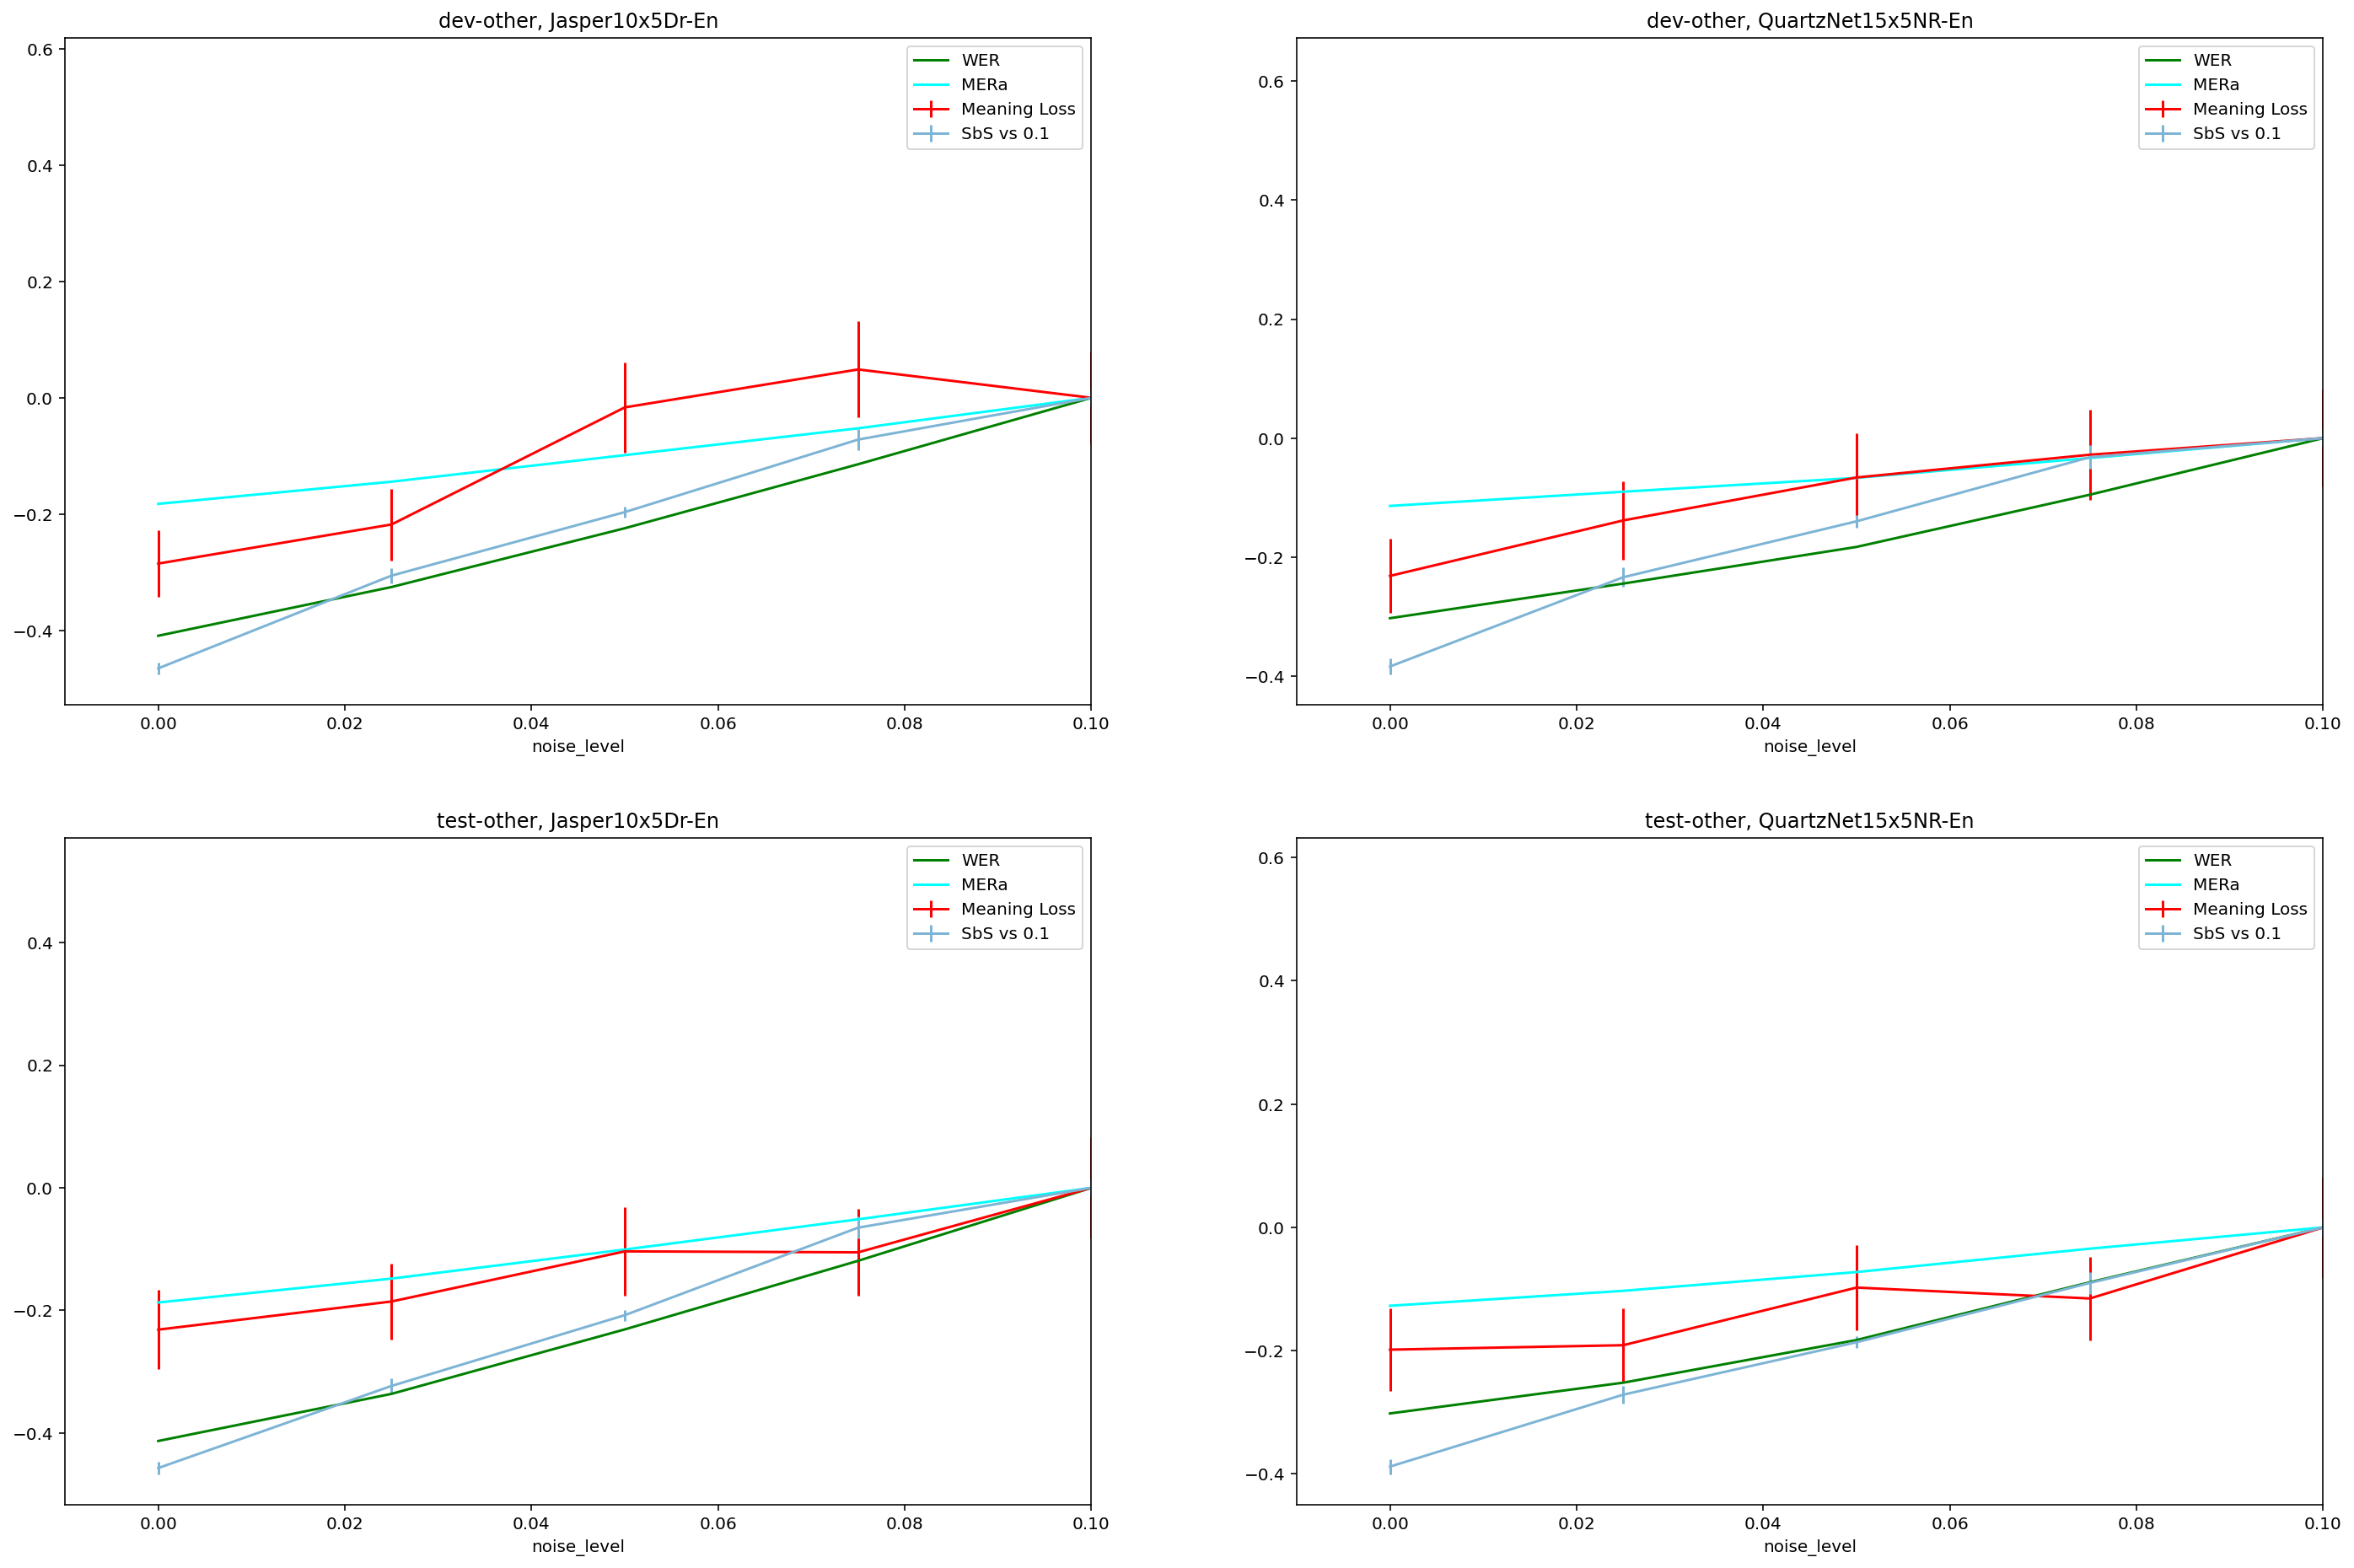

In [21]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

fig, axes = plt.subplots(2, 2, figsize=(24, 16))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

common_kwargs = {
    'xlim': [-0.01, 0.10],
    'subplots': True,
}

def normalize(df_slice, field='better'):
    df_slice = pd.DataFrame(df_slice)
    norm_value = df_slice[field].loc[df_slice['noise_idx'] == noise_from_value(0.10)].min()
    df_slice[field+'_norm'] = df_slice[field].apply(lambda x: (x - norm_value) / norm_value)
    if 'error' in df_slice:
        df_slice['error'] = df_slice.apply(lambda row: row['error'] * row[field] / norm_value, axis=1)
    return df_slice

def normalize_mera_sbs(df_slice, field='better'):
    df_slice = pd.DataFrame(df_slice)
    norm_value = df_slice[field].loc[df_slice['noise_level'] == 0.10].min()
    df_slice[field+'_norm'] = df_slice[field].apply(lambda x: (x - norm_value) / norm_value)
    if 'error' in df_slice:
        df_slice['error'] = df_slice.apply(lambda row: row['error'] * row[field] / norm_value, axis=1)
    return df_slice

i = 0
for dataset in wers_df.dataset.unique().tolist():
    j = 0
    for model in wers_df.model.unique().tolist():
        ax = axes[i, j]
        normalize(wers_df.loc[(wers_df['model'] == model) & (wers_df['dataset'] == dataset)], 'wer').plot.line(
            color='green',
            label='WER',
            x='noise_level',
            y='wer_norm',
            ax=ax,
            **common_kwargs
        )
        
        normalize(mean_mera_df.loc[(mean_mera_df['model'] == model) & (mean_mera_df['dataset'] == dataset)], 'mer').plot.line(
            color='cyan',
            label='MERa',
            x='noise_level',
            y='mer_norm',
            ax=ax,
            **common_kwargs
        )

        normalize(meaning_df.loc[(meaning_df['model'] == model) & (meaning_df['dataset'] == dataset)]).plot.line(
            color='red',
            label='Meaning Loss',
            x='noise_level',
            y='better_norm',
            yerr='error',
            ax=ax,
            **common_kwargs
        )
        k=0
        for sbs_basis, sbs_slice in sbs_slices.items():
            normalize(sbs_slice.loc[(sbs_slice['model'] == model) & (sbs_slice['dataset'] == dataset)]).plot.line(
                color=plt.cm.RdYlBu(k * 50 + 200),
                label= f'SbS vs {noise_from_index(sbs_basis)}',
                x='noise_level',
                y='better_norm',
                yerr='error',
                ax=ax,
                **common_kwargs
            )
            k+=1
        ax.set_title(f'{dataset}, {model}')
        j+=1
    i+=1